In [17]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/python/BayesianFiltering

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/python/BayesianFiltering'
/content/drive/MyDrive/python/BayesianFiltering


In [18]:
%%capture
!pip install jaxtyping
!pip install dynamax

In [19]:
from jax import numpy as jnp
from jax import jacfwd, jacrev, jit, vmap, lax, make_jaxpr
from jax import random as jr
from jax import tree_util as jtu
import jax
from functools import partial
import tensorflow

import gaussfiltax.utils as utils
import gaussfiltax.containers as containers
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import time
import gaussfiltax.inference as gf
import gaussfiltax.particlefilt as pf
from gaussfiltax.models import ParamsNLSSM, NonlinearGaussianSSM, NonlinearSSM, ParamsBPF

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [20]:
# Parameters
state_dim = 1
state_noise_dim = 1
emission_dim = 1
emission_noise_dim = 1
seq_length = 100
mu0 = jnp.zeros(state_dim)
Sigma0 = 1.0 * jnp.eye(state_dim)
Q = 1.0 * jnp.eye(state_noise_dim)
R = 100.0 * jnp.eye(emission_noise_dim)

# ICASSP
f1 = lambda x, q, u: (1-u) * x / 2.  + u * jnp.sin(10 * x) + q
g1 = lambda x, r, u:  0.1 * jnp.dot(x, x) + r
def g1lp(x,y,u):
    return MVN(loc = g1(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Lorenz 63
def lorentz_63(x, sigma=10, rho=28, beta=2.667, dt=0.01):
    dx = dt * sigma * (x[1] - x[0])
    dy = dt * (x[0] * rho - x[1] - x[0] *x[2]) 
    dz = dt * (x[0] * x[1] - beta * x[2])
    return jnp.array([dx+x[0], dy+x[1], dz+x[2]])
f63 = lambda x, q, u: lorentz_63(x) + q

# stochastic growth model
f3 = lambda x, q, u: x / 2. + 100. * x / (1 + jnp.power(x, 2)) * u + q
g3 = lambda x, r, u: 0.8 * x + r
def g3lp(x,y,u):
    return MVN(loc = g3(x, 0.0, u), covariance_matrix = R).log_prob(y)


# Stochastic Volatility
alpha = 0.91
sigma = 1.0
beta = 0.5
f = lambda x, q, u: alpha * x + sigma * q
h = lambda x, r, u: beta * jnp.exp(x/2) * r
def svlp(x,y,u):
    return MVN(loc = h(x, 0.0, u), covariance_matrix = h(x, 1.0, u)**2 * R).log_prob(y)

# Multivariate SV
Phi = 0.8 * jnp.eye(state_dim)
f_msv = lambda x, q, u: Phi @ x +  q
h_msv = lambda x, r, u: 0.5 * jnp.multiply(jnp.exp(x/2), r)
def msvlp(x,y,u):
    return MVN(loc = h_msv(x, 0.0, u), covariance_matrix = jnp.diag(jnp.exp(x/2.0)) @ R @ jnp.diag(jnp.exp(x/2.0))).log_prob(y)


# Inputs
# inputs = 1. * jnp.cos(0.1 * jnp.arange(seq_length))
sm = lambda x : jnp.exp(x) / (1+jnp.exp(x))
inputs = sm(jnp.arange(seq_length)-50) # off - on
# inputs = 1.0 * jnp.ones(seq_length) # on - on

In [21]:
f = f3
g = g1
glp = g1lp

In [22]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias=jnp.zeros(state_noise_dim),
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias=jnp.zeros(emission_noise_dim),
    emission_noise_covariance=R,
)

## Experiments

In [32]:
verbose = False
Nsim = 100
gsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)
next_key = jr.PRNGKey(0)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key, next_key = jr.split(next_key)
    states, emissions = model.sample(params, key, seq_length, inputs = inputs)
    

    # GSF
    M = 5
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    print('       Time taken for GSF: ', tout - tin)

    # AGSF
    tin = time.time()
    num_components = [M, 3, 3] # has to be set correctly OW "TypeError: Cannot interpret '<function <lambda> at 0x12eae3ee0>' as a data type". Check internal containers._branch_from_node
    posterior_filtered_agsf, aux_outputs = gf.augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = (1.0, 0.1), inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    print('       Time taken for AGSF: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 100

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=jnp.zeros(state_noise_dim),
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=jnp.zeros(emission_noise_dim),
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf, states))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf, states))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf, states))

    print('              GSF RMSE:', gsf_rmse[i])
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])


sim 1/100
       Time taken for GSF:  0.5603296756744385
       Time taken for AGSF:  3.990253210067749
       Time taken for BPF:  0.891000509262085
              GSF RMSE: 10.9642725
              AGSF RMSE: 6.8823533
              BPF RMSE: 10.36732
sim 2/100
       Time taken for GSF:  0.5866262912750244
       Time taken for AGSF:  5.142477989196777
       Time taken for BPF:  1.0458941459655762
              GSF RMSE: 7.167265
              AGSF RMSE: 6.9453335
              BPF RMSE: 8.215828
sim 3/100
       Time taken for GSF:  0.5825607776641846
       Time taken for AGSF:  3.872009754180908
       Time taken for BPF:  0.8679242134094238
              GSF RMSE: 9.523492
              AGSF RMSE: 6.952512
              BPF RMSE: 10.750964
sim 4/100
       Time taken for GSF:  0.5833799839019775
       Time taken for AGSF:  4.533349514007568
       Time taken for BPF:  1.3689000606536865
              GSF RMSE: 10.483874
              AGSF RMSE: 19.8766
              BPF RMSE: 8

In [35]:
bpf_rmse

Array([10.36732  ,  8.215828 , 10.750964 ,  8.799666 , 11.515625 ,
       10.9682255,  8.855206 ,  3.9908197, 11.679954 ,  8.977736 ,
       10.796018 ,  7.688621 ,  8.232765 ,  9.891479 ,  8.502141 ,
        8.230677 ,  7.837368 , 10.370967 ,  8.589087 , 10.816307 ,
        8.337646 , 11.679473 , 10.254138 ,  7.1510324,  9.050857 ,
        9.3895855,  9.273965 ,  9.52309  ,  8.664582 , 13.017562 ,
        8.313485 ,  9.164206 ,  9.721111 , 13.386581 ,  9.213348 ,
        8.795565 ,  9.258376 ,  6.8938756, 12.097391 , 10.686058 ,
        8.554623 ,  9.2516985,  9.441323 , 12.472943 , 10.36135  ,
        5.327312 ,  7.8925805, 11.498224 ,  5.3988576,  8.403975 ,
       10.558807 , 10.048604 ,  7.894642 ,  7.7883115,  8.331407 ,
        9.057516 , 10.169492 , 11.604409 ,  9.278841 , 10.563904 ,
        7.849472 ,  6.84585  ,  6.6401954, 13.4616785, 13.6773815,
        9.0884075,  8.194022 , 10.191587 ,  9.539793 , 12.01545  ,
       10.001626 ,  8.708886 ,  7.8836975,  7.5740323,  6.1274

In [2]:
from jax import numpy as jnp
a = jnp.array([1,2,3,4,5,6,7,8,9,10])
ind = jnp.argpartition(a, -4)[-4:]

In [33]:
import pandas as pd
gsf_armse = jnp.mean(gsf_rmse)
agsf_armse = jnp.mean(agsf_rmse)
bpf_armse = jnp.mean(bpf_rmse)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_rmse))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_rmse))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_rmse))

# gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, np.std(gsf_time))
# agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, np.std(agsf_time))
# bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, np.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
df[' '] = ['GSF', 'AGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, agsf_tab_out, bpf_tab_out]
#  df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))  
df

\begin{tabular}{lll}
\toprule
     &                  RMSE & time(s) \\
\midrule
 GSF &        nan±       nan &     NaN \\
AGSF &       8.97±      5.45 &     NaN \\
 BPF &       9.52±      1.80 &     NaN \\
\bottomrule
\end{tabular}



<ipython-input-33-84c30aa12b10>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


,,RMSE,time(s)
0,GSF,nan± nan,NaN
1,AGSF,8.97± 5.45,NaN
2,BPF,9.52± 1.80,NaN


## Plots

In [ ]:
plt.plot(gsf_mse)
plt.plot(agsf_mse)
plt.plot(bpf_mse)
plt.legend(['GSF', 'AGSF', 'BPF'])
plt.show()

In [ ]:
plt.plot(states)
plt.plot(point_estimate_gsf)
plt.plot(point_estimate_agsf)
plt.plot(point_estimate_bpf)
plt.legend(['x','gsf', 'agsf', 'bpf'])
plt.show()

### GSF

In [ ]:
num_components = M

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_gsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")
#axes[0].legend(leg)

if state_dim ==1:
    for m in range(M):
        axes[1].plot(posterior_filtered_gsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

for m in range(M):
    axes[2].plot(posterior_filtered_gsf.weights[m])
    axes[2].set_title("weights")

axes[3].plot(states, label="xs")
leg = ["states", "GSF"]
axes[3].plot(point_estimate_gsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")
plt.show()

### AGSF

TypeError: ignored

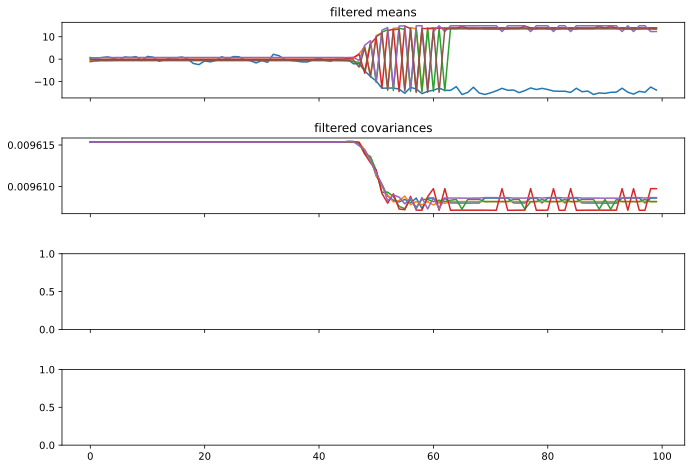

In [26]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(M):
    axes[0].plot(posterior_filtered_agsf.means[m])
    leg.append("model {}".format(m))
    axes[0].set_title("filtered means")

#axes[0].legend(leg)

if state_dim == 1:
    for m in range(M):
        axes[1].plot(posterior_filtered_agsf.covariances[m].squeeze())
        axes[1].set_title("filtered covariances")

else:
    for m in range(jnp.prod(num_components)):
        axes[1].plot(aux_outputs["updated_means"][:,m])
        axes[1].set_title("updated means")

for m in range(jnp.prod(num_components)):
        axes[2].plot(aux_outputs["pre_weights"][:,m])
        axes[2].set_title("updated pre_weights")

axes[3].plot(states, label="xs")
leg = ["states", "AGSF"]
axes[3].plot(point_estimate_agsf)
axes[3].legend(leg)
axes[3].set_title("point estimate")

plt.show()

In [ ]:
# plot Deltas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Deltas"].shape[0]):
    plt.plot(aux_outputs["Deltas"][i, :, 0])
plt.title('Deltas')
plt.show()

# plot Lambdas
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["Lambdas"].shape[0]):
    plt.plot(aux_outputs["Lambdas"][i, :, 0])
plt.title('Lambdas')
plt.show()

# plot grads_dyn
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][i, :, 0, 0])
plt.title('grad_dyn')
plt.show()

# plot grads_obs
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_obs"].shape[0]):
    plt.plot(aux_outputs["grads_obs"][i, :, 0, 0])
plt.title('grad_obs')
plt.show()

# plot gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["gain"].shape[0]):
    plt.plot(aux_outputs["gain"][i, :, 0, 0])
plt.title('gain')
plt.show()

# plot grads_dyn / gain
plt.figure(figsize=(10, 1))
for i in range(aux_outputs["grads_dyn"].shape[0]):
    plt.plot(aux_outputs["grads_dyn"][:, i, 0, 0] / aux_outputs["gain"][:, i * 3, 0, 0])
plt.title('grad / gain')
plt.show()

### BPF

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
fig.tight_layout(pad=3.0)
axes[0].plot(states, label="xs")
leg = ["states"]
for m in range(num_particles):
    axes[0].plot(posterior_bpf["particles"][m])
    leg.append("model {}".format(m))
    axes[0].set_title("particles")

for m in range(num_particles):
    axes[1].plot(posterior_bpf["weights"][m])
    axes[1].set_title("weights")

plt.show()